# Notebook for Quality Control demonstration of tonykong.me

This notebook aims for storing calculations and demonstrations of blo related to quality controls in tonykong.me. This notebook will be devided by the date release of a blog article, and will further devide by each of the functions demonstrated in that article.

## Blog on 16 September 2023

### 1. Demonstration of CDF of Gaussian distribution under 1s

In [7]:
#import numpy and matplotlib
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

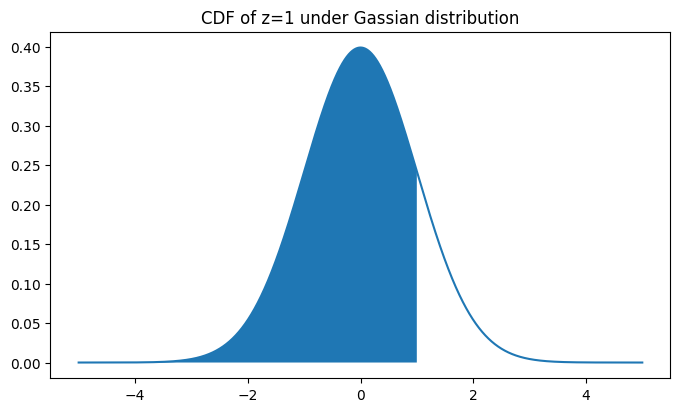

In [8]:
#create an array from -5 to 5 with interval of 0.001
n_range = np.arange(-5, 5, 0.001)

#plot the curve in matplotlib plotting chart
plt.figure(figsize = (8, 4.5))
plt.plot(n_range, st.norm.pdf(n_range, 0, 1))

#plot the area under curve between -5 to 1, to mimick the cdf of z-score = 3abs
plot_range = n_range[n_range< 1]
plt.fill_between(plot_range, 0, st.norm.pdf(plot_range, 0, 1))
plt.title('CDF of z=1 under Gassian distribution')
plt.show()

# Blog on 2 October 2023
## Simulation of multirules 

## 1. Creation of 1 million of standard Gaussian distribution

In [9]:
#import numpy, pandas, scipy stats and math
import numpy as np
import pandas as pd
import scipy.stats as st
import math

In [10]:
np.random.seed(42)
qc_list = dict()
for i in range(1, 7):
    qc_list['QC{}'.format(i)] = np.random.normal(0,1,size=1000000)

In [11]:
qc_df = pd.DataFrame(qc_list)

In [12]:
qc_df.head()

,QC1,QC2,QC3,QC4,QC5,QC6
0,0.496714,0.169172,1.064722,-1.107160,-0.184006,-0.202746
1,-0.138264,-0.121505,-0.496713,-1.769362,0.043793,0.910803
2,0.647689,1.156625,0.129260,-0.337808,1.182518,1.041890
3,1.523030,0.200086,-1.479693,0.502378,-0.284320,0.397202
4,-0.234153,0.864611,-0.309847,0.443503,-0.325154,0.360989


## 2. Construct the QC multirule for checking within QC and across QC violations

In [13]:
#Constructing QC rule check for each number of levels and rules

def qc_check(sd, length, qc_df=qc_df, qc_levels = [1,2,3,4,6], printing = True):
    
    for l in qc_levels:
        if length != 'R':
            #creating qc levels and multirule columns with default value False
            current_l_qc = 'QC_L={}_{}-{}s'.format(l, length, sd)
            qc_df[current_l_qc] = False
            
            #create a l-length violation list for storing number of the exceeding limits,
            #and a count for across qc violation
            within_qc_exceeds = [0]*l
            across_qc_exceeds = 0
            
            
            for row in range(len(qc_df)):
                current_exceeds = [0]*l
                    
                for n in range(1, l+1):
                    
                    current_qc_value = qc_df.loc[row, 'QC{}'.format(n)]
                                                 
                    #Calculating exceeding situations
                    if current_qc_value > sd:
                        current_exceeds[n-1] += 1
                    elif current_qc_value < -sd:
                        current_exceeds[n-1] -= 1
                    else:
                        current_exceeds[n-1] = 0
                    
                    #Adding number of excceding violations to within_qc_exceeds
                for i in range(len(current_exceeds)):
                    if current_exceeds[i]!= 0:
                        if within_qc_exceeds[i] > 0 and current_exceeds[i] > 0:
                            within_qc_exceeds[i] += current_exceeds[i]
                        elif within_qc_exceeds[i] < 0 and current_exceeds[i] < 0:
                            within_qc_exceeds[i] += current_exceeds[i]
                        else:
                            within_qc_exceeds[i] = current_exceeds[i]
                    else:
                        within_qc_exceeds[i] = 0
                
                #Determine within-QC level violation
                if max(within_qc_exceeds) >= length or min(within_qc_exceeds) <= -length:
                    qc_df.loc[row, current_l_qc] = True
                    within_qc_exceeds = [0]*l
                    across_qc_exceeds = 0
                
                    
                #Adding count to across-QC violation either 
                #1. if number of QC level exceeds > length limit (violation), 
                #2. or number of levels exceed limits + historical across qc violation in same direction > length limit
                #3.or all levels exceed limits in same direction
                current_positive_exceeds = sum(n>0 for n in current_exceeds)
                current_negative_exceeds = sum(n<0 for n in current_exceeds)
                #Procees #1: determine QC violation
                if l == 1 or length == 1:
                    pass
                elif current_positive_exceeds >= length or current_negative_exceeds >= length:
                    qc_df.loc[row, current_l_qc] = True
                    within_qc_exceeds = [0]*l
                    across_qc_exceeds = 0
                #Process #2: determine QC violation
                elif current_positive_exceeds + across_qc_exceeds >= length or (-current_negative_exceeds) + across_qc_exceeds <= -length:
                    qc_df.loc[row, current_l_qc] = True
                    within_qc_exceeds = [0]*l
                    across_qc_exceeds = 0
                #Process #3: Add to across_qc_exceeds
                elif abs(sum(current_exceeds)) == l:
                    #If same direction, add; if not, replace.
                    if sum(current_exceeds)*across_qc_exceeds >=0:
                        across_qc_exceeds += sum(current_exceeds)
                    else:
                        across_qc_exceeds = sum(current_exceeds)
                #Elsewhere situation will reset the across qc exceeds parameter
                else:
                    across_qc_exceeds = 0
            if printing:
                print('{}-{}s rule L={} checking completed'.format(length, sd, l))

        else:
            #Handling of R-4s
            qc_df['QC_L={}_R-4s'.format(l)] = False
            last_qcs = [0]*l
            reset = False
            for row in range(len(qc_df)):
                for i in range(1, l+1):
                    current_value = qc_df.loc[row, 'QC{}'.format(i)]
                    #Determine within-QC level violations
                    if abs(current_value - last_qcs[i-1]) > sd:
                        qc_df.loc[row, 'QC_L={}_R-4s'.format(l)] = True
                        reset = True
                    last_qcs[i-1] = current_value
                #Determine across-QC level violations
                if max(last_qcs) - min(last_qcs) > sd:
                    qc_df.loc[row, 'QC_L={}_R-4s'.format(l)] = True
                    reset = True
                #Execute reset
                if reset == True:
                    last_qcs = [0]*l
                    reset = False

In [14]:
#Check all the Multirules
qc_check(sd=3, length = 1)
qc_check(sd=2, length = 2)
qc_check(sd=4, length = 'R')
qc_check(sd=1, length = 4)
qc_check(sd=0, length = 10)

1-3s rule L=1 checking completed
1-3s rule L=2 checking completed
1-3s rule L=3 checking completed
1-3s rule L=4 checking completed
1-3s rule L=6 checking completed
2-2s rule L=1 checking completed
2-2s rule L=2 checking completed
2-2s rule L=3 checking completed
2-2s rule L=4 checking completed
2-2s rule L=6 checking completed
4-1s rule L=1 checking completed
4-1s rule L=2 checking completed
4-1s rule L=3 checking completed
4-1s rule L=4 checking completed
4-1s rule L=6 checking completed
10-0s rule L=1 checking completed
10-0s rule L=2 checking completed
10-0s rule L=3 checking completed
10-0s rule L=4 checking completed
10-0s rule L=6 checking completed


In [15]:
#spotcheck QC quality
print([sum(qc_df['QC_L={}_{}'.format(x, '10-0s')] == True) for x in [1, 2, 3, 4, 6]])

[951, 3186, 5562, 8459, 15551]


## 3. Observed probability statistics for each of QC multirules

In [16]:
#Return results
individual_rule_dict = dict()
n_list = [1,2,3,4,6]
rule_list = ['1-3s', '2-2s', 'R-4s', '4-1s', '10-0s']
df_len = len(qc_df)

#Runing total numbers
for n in n_list:
    temp_list = []
    for rule in rule_list:
        temp_list.append(sum(qc_df['QC_L={}_{}'.format(n, rule)]))
    individual_rule_dict['n={}_total_number'.format(n)] = temp_list

#Running probability
for n in n_list:
    individual_rule_dict['n={}_probability'.format(n)] = [i/df_len for i in individual_rule_dict['n={}_total_number'.format(n)]]
    individual_rule_dict['n={}_ARL'.format(n)] = [round((1/i), 2) for i in individual_rule_dict['n={}_probability'.format(n)]]
    individual_rule_dict['n={}_95%CI'.format(n)] = ['{:.6f} - {:.6f}'.format(i-math.sqrt((i*(1-i)/df_len))*1.96,
                                                           i+math.sqrt((i*(1-i)/df_len))*1.96)
                                          for i in individual_rule_dict['n={}_probability'.format(n)]]
    

In [17]:
#Convert the dictionary to data frame
individual_rule_probabilities = pd.DataFrame(data = individual_rule_dict, 
                                             index= rule_list).transpose()

In [18]:
#Rearrange rows
index_list_1 = []
for i in [1,2,3,4,6]:
    for j in ['_total_number', '_probability', '_95%CI', '_ARL']:
        index_list_1.append('n='+str(i)+j)
individual_rule_probabilities = individual_rule_probabilities.reindex(index_list_1)

In [19]:
#Show results
individual_rule_probabilities

,1-3s,2-2s,R-4s,4-1s,10-0s
n=1_total_number,2638,960,4341,1062,951
n=1_probability,0.002638,0.00096,0.004341,0.001062,0.000951
n=1_95%CI,0.002537 - 0.002739,0.000899 - 0.001021,0.004212 - 0.004470,0.000998 - 0.001126,0.000891 - 0.001011
n=1_ARL,379.08,1041.67,230.36,941.62,1051.52
n=2_total_number,5422,2926,12190,3202,3186
n=2_probability,0.005422,0.002926,0.01219,0.003202,0.003186
n=2_95%CI,0.005278 - 0.005566,0.002820 - 0.003032,0.011975 - 0.012405,0.003091 - 0.003313,0.003076 - 0.003296
n=2_ARL,184.43,341.76,82.03,312.3,313.87
n=3_total_number,8101,5722,22727,6148,5562
n=3_probability,0.008101,0.005722,0.022727,0.006148,0.005562


In [20]:
#save results to csv
individual_rule_probabilities.to_csv('individual_rule_probabilities.csv', sep='\t')

## 4. Observed probability statistics for each of QC combined multirules

In [21]:
#Combining the QC
for n in n_list:
    qc_list = ['QC_L={}_'.format(n)+i for i in ['1-3s', '2-2s', 'R-4s', '4-1s', '10-0s']]
    qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s'.format(n)] = qc_df[qc_list[0:3]].any(axis='columns')
    qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s/4-1s'.format(n)] = qc_df[qc_list[0:4]].any(axis='columns')
    qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s/4-1s/10-x'.format(n)] = qc_df[qc_list[0:5]].any(axis='columns')

In [22]:
#generating the counts of violations
multi_rule_list = ['1-3s', '1-3s/2-2s/R-4s', '1-3s/2-2s/R-4s/4-1s', '1-3s/2-2s/R-4s/4-1s/10-x']
multi_rule_dict = dict()

for n in n_list:
    temp_list = []
    for rule in multi_rule_list:
        temp_list.append(sum(qc_df['QC_L={}_{}'.format(n, rule)]))
    multi_rule_dict['n={}_total_number'.format(n)] = temp_list

#Running probability
for n in n_list:
    multi_rule_dict['n={}_probability'.format(n)] = [i/df_len for i in multi_rule_dict['n={}_total_number'.format(n)]]
    multi_rule_dict['n={}_ARL'.format(n)] = [round((1/i), 2) for i in multi_rule_dict['n={}_probability'.format(n)]]
    multi_rule_dict['n={}_95%CI'.format(n)] = ['{:.6f} - {:.6f}'.format(i-math.sqrt((i*(1-i)/df_len))*1.96,
                                                           i+math.sqrt((i*(1-i)/df_len))*1.96)
                                          for i in multi_rule_dict['n={}_probability'.format(n)]]

In [23]:
#Adding the dictionary to data frame
multi_rule_probabilities = pd.DataFrame(data = multi_rule_dict, 
                                             index= multi_rule_list).transpose()

In [24]:
#Rearrange the rows
multi_rule_probabilities = multi_rule_probabilities.reindex(index_list_1)

In [25]:
#Display results
multi_rule_probabilities

,1-3s,1-3s/2-2s/R-4s,1-3s/2-2s/R-4s/4-1s,1-3s/2-2s/R-4s/4-1s/10-x
n=1_total_number,2638,7278,8313,9258
n=1_probability,0.002638,0.007278,0.008313,0.009258
n=1_95%CI,0.002537 - 0.002739,0.007111 - 0.007445,0.008135 - 0.008491,0.009070 - 0.009446
n=1_ARL,379.08,137.4,120.29,108.01
n=2_total_number,5422,17889,20914,24013
n=2_probability,0.005422,0.017889,0.020914,0.024013
n=2_95%CI,0.005278 - 0.005566,0.017629 - 0.018149,0.020634 - 0.021194,0.023713 - 0.024313
n=2_ARL,184.43,55.9,47.81,41.64
n=3_total_number,8101,30920,36659,41947
n=3_probability,0.008101,0.03092,0.036659,0.041947


In [26]:
#save results to csv
multi_rule_probabilities.to_csv('multi_rule_probabilities.csv', sep='\t')

#  Blog on 14 Feb 2024


## Step 1: Generate 10k set of random numbers (N=6) of Guassian Distributions

In [131]:
def power_function_multirule(n_qc=10000, N=6, mean=0, sd=1, step=0.01, start=0, end=6.01, step_changes='mean'):
    ##pre-setup
    final_dict = {'mean':[], 'sd':[], 'N':[], 'n_qc':[], '1-3s':[], 
                      '1-3s/2-2s/R-4s':[], '1-3s/2-2s/R-4s/4-1s':[], '1-3s/2-2s/R-4s/4-1s/10-x':[]}
    multirule_list = ['1-3s', '1-3s/2-2s/R-4s', '1-3s/2-2s/R-4s/4-1s', '1-3s/2-2s/R-4s/4-1s/10-x']
    
    ## Generating lists
    for i in np.arange(start, end, step):
        qc_list = dict()
        for j in range(0,N):
            if step_changes == 'mean':
                qc_list['QC{}'.format(j+1)] = np.random.normal(i, sd, n_qc)
            elif step_changes == 'sd':
                qc_list['QC{}'.format(j+1)] = np.random.normal(mean, i, n_qc)
            else:
                raise ValueError  
        qc_df = pd.DataFrame(qc_list)
        
        ## Applying rules
        print('Currently working on {} at {:.2f}'.format(step_changes, i))
        qc_check(sd=3, qc_df=qc_df, length = 1, printing = False)
        qc_check(sd=2, qc_df=qc_df, length = 2, printing = False)
        qc_check(sd=4, qc_df=qc_df, length = 'R', printing = False)
        qc_check(sd=1, qc_df=qc_df, length = 4, printing = False)
        qc_check(sd=0, qc_df=qc_df, length = 10, printing = False)
        
        ## Combining rules
        for n in [1,2,3,4,6]:
            qc_list = ['QC_L={}_'.format(n)+i for i in ['1-3s', '2-2s', 'R-4s', '4-1s', '10-0s']]
            qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s'.format(n)] = qc_df[qc_list[0:3]].any(axis='columns')
            qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s/4-1s'.format(n)] = qc_df[qc_list[0:4]].any(axis='columns')
            qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s/4-1s/10-x'.format(n)] = qc_df[qc_list[0:5]].any(axis='columns')
        #return(qc_df)
    
        ## Counting rules violations
        for r in [1,2,3,4,6]:
            if step_changes == 'mean':
                final_dict['mean'].append(i)
                final_dict['sd'].append(sd)
            else:
                final_dict['mean'].append(mean)
                final_dict['sd'].append(i)
            final_dict['N'].append(r)
            final_dict['n_qc'].append(n_qc)
            for s in multirule_list:
                final_dict[s].append(sum(qc_df['QC_L={}_{}'.format(r, s)])/n_qc)
    return pd.DataFrame(final_dict)

## Step 2: Generate random numbers for different bias and shift

In [235]:
power_function_bias = power_function_multirule(n_qc=10000, N=6, mean=0, sd=1, step=0.1, 
                                               start=0, end=6.1, step_changes='mean')
power_function_shift = power_function_multirule(n_qc=10000, N=6, mean=0, sd=1, step=0.1, 
                                               start=1, end=7.1, step_changes='sd')

Currently working on mean at 0.00
Currently working on mean at 0.10
Currently working on mean at 0.20
Currently working on mean at 0.30
Currently working on mean at 0.40
Currently working on mean at 0.50
Currently working on mean at 0.60
Currently working on mean at 0.70
Currently working on mean at 0.80
Currently working on mean at 0.90
Currently working on mean at 1.00
Currently working on mean at 1.10
Currently working on mean at 1.20
Currently working on mean at 1.30
Currently working on mean at 1.40
Currently working on mean at 1.50
Currently working on mean at 1.60
Currently working on mean at 1.70
Currently working on mean at 1.80
Currently working on mean at 1.90
Currently working on mean at 2.00
Currently working on mean at 2.10
Currently working on mean at 2.20
Currently working on mean at 2.30
Currently working on mean at 2.40
Currently working on mean at 2.50
Currently working on mean at 2.60
Currently working on mean at 2.70
Currently working on mean at 2.80
Currently work

In [243]:
power_function_bias
power_function_bias.to_csv('bias.csv', index=False)

In [244]:
power_function_shift
power_function_shift.to_csv('random error.csv', index=False)

## Step 3: Plot the power function graphs

In [238]:
def power_function_graph(df, param, desc):

    fig, axs = plt.subplots(1, 4)
    fig.suptitle('Power Function Curves of different Multirules with {}'.format(desc), fontsize = 'xx-large')
    fig.supylabel('Probability', x = 0.1)
    fig.supxlabel(desc)
    fig.set_figheight(6)
    fig.set_figwidth(26)
    plt.rcParams['axes.grid'] = True

    for k in range(4):
        sub_table = df[df['N']==k+1]
        line1, = axs[k].plot(sub_table[param], sub_table.iloc[:,4], linestyle = ':', color = 'tab:blue', label=sub_table.columns[4])
        line2, = axs[k].plot(sub_table[param], sub_table.iloc[:,5], linestyle = '-.', color = 'tab:green', label=sub_table.columns[5])
        line3, = axs[k].plot(sub_table[param], sub_table.iloc[:,6], linestyle = '--', color = 'tab:purple',label=sub_table.columns[6])
        line4, = axs[k].plot(sub_table[param], sub_table.iloc[:,7], linestyle = '-', color = 'tab:red', label =sub_table.columns[7])
        axs[k].set_title('N ={}'.format(k+1))
    fig.legend(handles = [line1, line2, line3, line4])
    plt.show()
    fig.savefig('{}.jpg'.format(param))
    plt.clf()



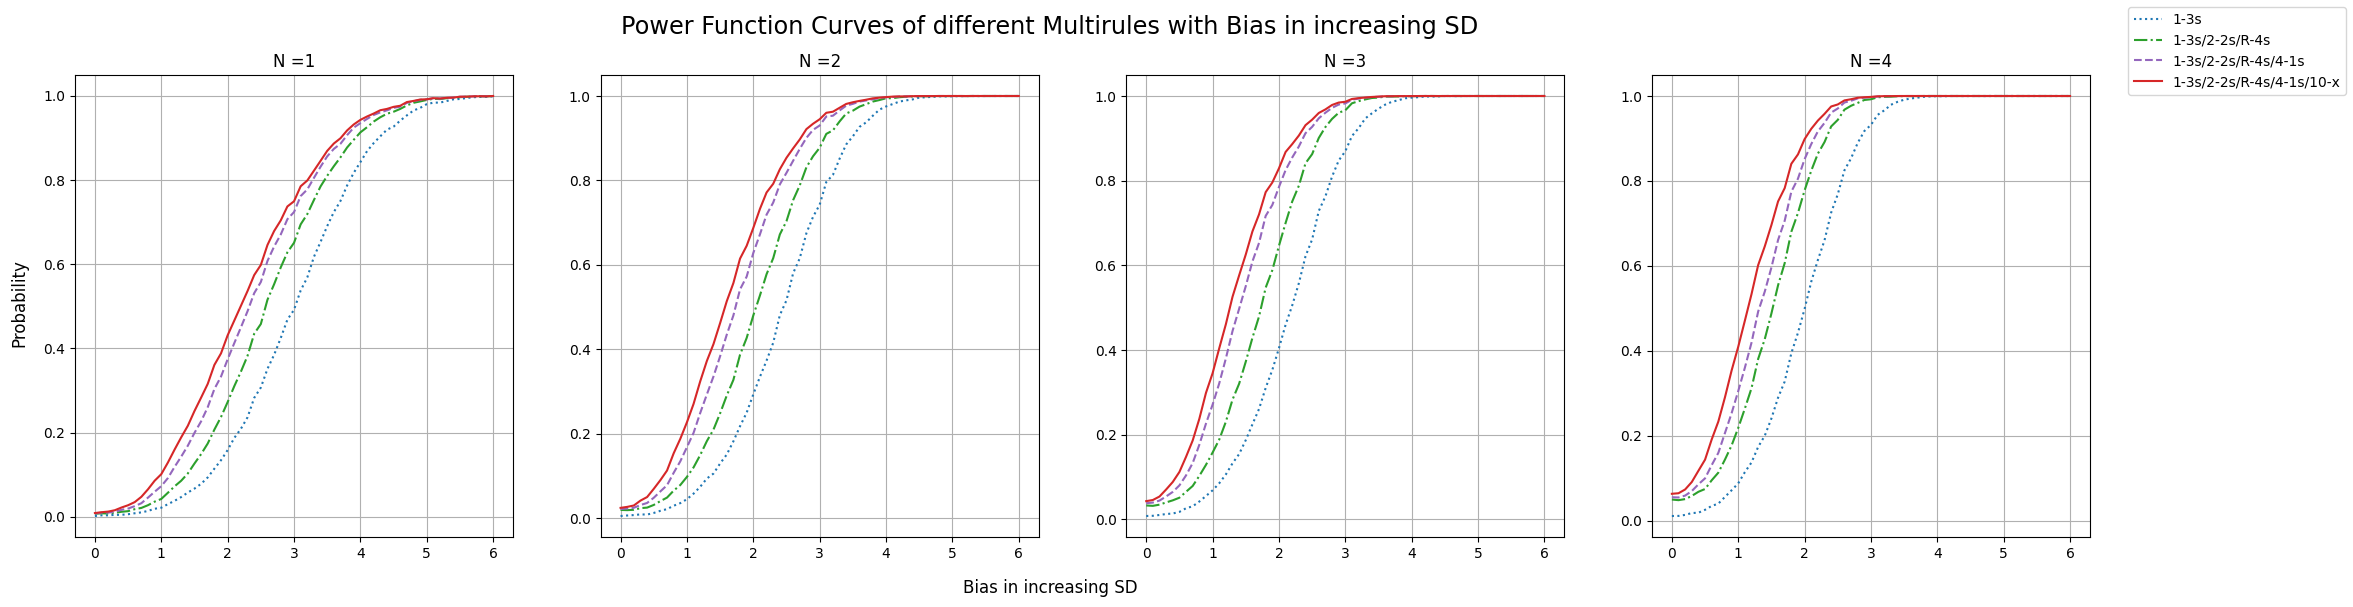

<Figure size 640x480 with 0 Axes>

In [239]:
power_function_graph(power_function_bias, 'mean', 'Bias in increasing SD')

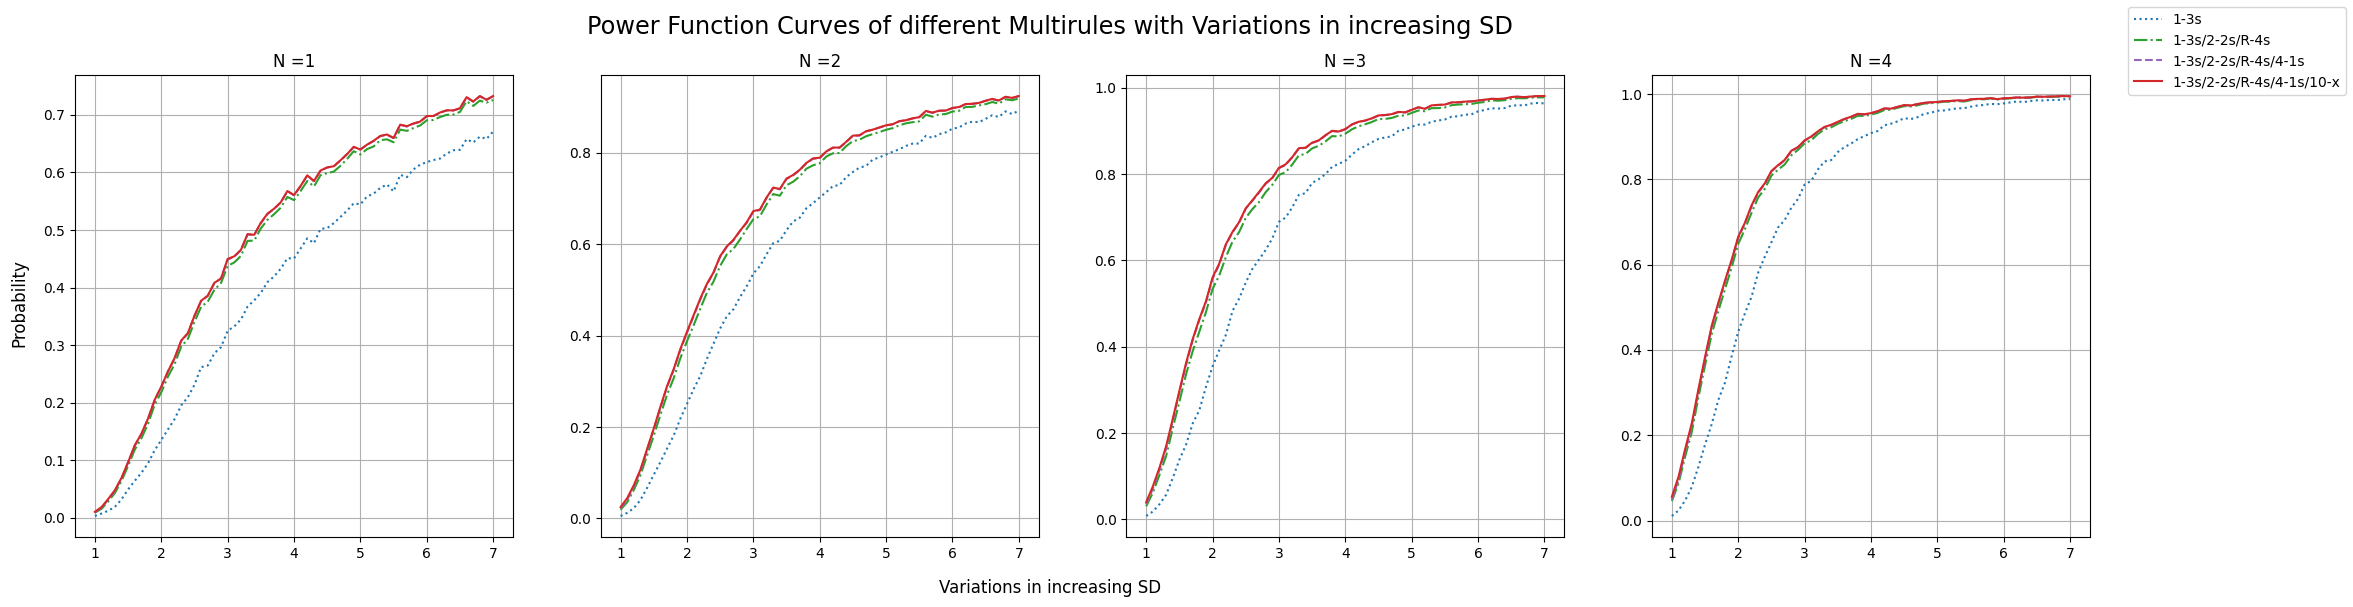

<Figure size 640x480 with 0 Axes>

In [240]:
power_function_graph(power_function_shift, 'sd', 'Variations in increasing SD')